# Quick tutorial for `PICASA` training and results analysis using simulated dataset.



In [2]:
import picasa
import anndata as an
import glob
import os

import matplotlib.pylab as plt
import scanpy as sc


Here, we will use simulated cancer patient data from two patients. The dataset is generated using `splatter`.

First, lets read the simulated cancer patient data from two diffrent patients from `data` directory as anndata objects.

In [3]:
sample = 'sim'

wdir = os.getcwd()
ddir = wdir +'/data/'

pattern = sample+'_*.h5ad'

In [3]:


file_paths = glob.glob(os.path.join(ddir, pattern))
file_names = [os.path.basename(file_path) for file_path in file_paths]

batch_map = {}
batch_count = 0
for file_name in file_names:
	print(file_name)
	batch_map[file_name.replace('.h5ad','').replace(sample+'_','')] = an.read_h5ad(ddir+file_name)
	batch_count += 1


sim_patient1.h5ad
sim_patient2.h5ad


Create picasa object and link the data.

Here, pairing mode is sequential (default) and neighbour search method is approximate using `Annoy`. 

In [4]:
picasa_object = picasa.create_picasa_object(
	batch_map,
    sample,
	wdir
 	)

picasa_object

Batch pair mode is - seq


Setup parameters for common net of `PICASA`.

In [5]:
common_epochs = 1
common_meta_epoch = 5

params = {'device' : 'cuda',
		'batch_size' : 100,
		'input_dim' : 1000,
		'embedding_dim' : 1000,
		'attention_dim' : 15,
		'latent_dim' : 15,
		'encoder_layers' : [100,15],
		'projection_layers' : [25,25],
		'learning_rate' : 0.001,
		'pair_search_method' : 'approx_50',
        'pair_importance_weight': 0.1,
	 	'corruption_tol' : 10.0,
        'cl_loss_mode' : 'none', 
		'epochs': common_epochs,
		'meta_epochs': common_meta_epoch
		}   

Run `PICASA` training - 
First, estimate neighbour pair for each cell in the dataset, and then train the model.

In [6]:
picasa_object.estimate_neighbour(params['pair_search_method'])
picasa_object.set_nn_params(params)
picasa_object.train_common()
picasa_object.plot_loss(tag='common')


Pair search method - approx_50
Generating neighbour using approximate method - ANNOY...
patient1_((3000, 1000)) >patient2_((2900, 1000))
Generating neighbour using approximate method - ANNOY...
patient2_((2900, 1000)) >patient1_((3000, 1000))
Pair search estimate is complete.
Starting PICASA common training...
{'device': 'cuda', 'batch_size': 100, 'input_dim': 1000, 'embedding_dim': 1000, 'attention_dim': 15, 'latent_dim': 15, 'encoder_layers': [100, 15], 'projection_layers': [25, 25], 'learning_rate': 0.001, 'pair_search_method': 'approx_50', 'pair_importance_weight': 0.1, 'corruption_tol': 10.0, 'cl_loss_mode': 'none', 'epochs': 1, 'meta_epochs': 5}
PICASACommonNet(
  (embedding): GeneEmbedor(
    (embedding): Embedding(1000, 15)
    (emb_norm): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  )
  (attention): ScaledDotAttention()
  (pooling): AttentionPooling()
  (encoder): ENCODER(
    (fc): Stacklayers(
      (layers): ModuleList(
        (0): Linear(in_features=1000, out_fe

Once training is completed, the following files are generated in the results directory - 

- picasa_common_train_loss.txt.gz
- picasa_common_train_loss.png

- Common net model file - picasa_common.model

Next, run inference to generate common latent space for all cells in the dataset.

In [7]:
device = 'cpu'
picasa_object.nn_params['device'] = device
eval_batch_size = 500
picasa_object.eval_common(eval_batch_size,device)

eval :patient1_patient2
eval :patient2_patient1


Next, train unique and base net model for entire dataset without variable gene selection. 

In [8]:
adata_combined = an.concat(picasa_object.data.adata_list, axis=0, join="outer")
adata_combined

AnnData object with n_obs × n_vars = 5900 × 1000
    obs: 'celltype', 'batch'

Setup for unique net model.

In [9]:
unique_epoch = 250
base_epoch = 250

input_dim = picasa_object.data.adata_list[picasa_object.adata_keys[0]].X.shape[1]
enc_layers = [128,15]
unique_latent_dim = 15
common_latent_dim = picasa_object.result.obsm['common'].shape[1]
dec_layers = [128,128]

Training for unique net model.

Then, run inference to generate unique latent space for all cells in the dataset.

In [10]:


picasa_object.train_unique(adata_combined, enc_layers,common_latent_dim,unique_latent_dim,dec_layers,l_rate=0.001,epochs=unique_epoch,batch_size=128,device='cuda')
picasa_object.plot_loss(tag='unq')
eval_batch_size = 10
picasa_object.eval_unique(adata_combined, enc_layers,common_latent_dim,unique_latent_dim,dec_layers,eval_batch_size,device='cuda')


PICASAUniqueNet(
  (u_encoder): MLP(
    (fc): Stacklayers(
      (layers): ModuleList(
        (0): Linear(in_features=1000, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
        (4): Linear(in_features=128, out_features=15, bias=True)
        (5): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (u_decoder): MLP(
    (fc): Stacklayers(
      (layers): ModuleList(
        (0): Linear(in_features=30, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

Training... PICASE unique model.
====> Epoch: 0 Average loss: 1257.0936
====> Epoch: 10 Average loss: 964.8452
====> Epoch: 20 Average loss: 910.4597
====> Epoch: 30 Average loss: 870.9267
====> Epoch: 40 Average loss: 841.1781
====> Epoch: 50 Average loss: 819.1198
====> Epoch: 60 Average loss: 802.1423
====> Epoch: 70 Average loss: 789.0384
====> Epoch: 80 Average loss: 779.2230
====> Epoch: 90 Average loss: 771.4095
====> Epoch: 100 Average loss: 765.5521
====> Epoch: 110 Average loss: 760.6812
====> Epoch: 120 Average loss: 756.7449
====> Epoch: 130 Average loss: 753.6050
====> Epoch: 140 Average loss: 751.2367
====> Epoch: 150 Average loss: 749.2876
====> Epoch: 160 Average loss: 747.4220
====> Epoch: 170 Average loss: 746.2559
====> Epoch: 180 Average loss: 745.3207
====> Epoch: 190 Average loss: 744.4906
====> Epoch: 200 Average loss: 743.4150
====> Epoch: 210 Average loss: 742.9610
====> Epoch: 220 Average loss: 742.4893
====> Epoch: 230 Average loss: 742.1227
====> Epoch: 240 

Once unique net training is completed, the following files are generated in the results directory - 

- picasa_unique_train_loss.txt.gz
- picasa_unique_train_loss.png

- Unique net model file - picasa_unique.model

Run base net model to estimate base latent space (no decomposition into common and unique) for all cells in the dataset.

In [11]:
latent_dim=picasa_object.result.obsm['common'].shape[1]
picasa_object.train_base(adata_combined, enc_layers,latent_dim,dec_layers,l_rate=0.001,epochs=base_epoch,batch_size=128,device='cuda')
picasa_object.plot_loss(tag='base')
eval_batch_size = 10
picasa_object.eval_base(adata_combined, enc_layers,latent_dim,dec_layers,eval_batch_size,device='cuda')


PICASABaseNet(
  (u_encoder): MLP(
    (fc): Stacklayers(
      (layers): ModuleList(
        (0): Linear(in_features=1000, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
        (4): Linear(in_features=128, out_features=15, bias=True)
        (5): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (u_decoder): MLP(
    (fc): Stacklayers(
      (layers): ModuleList(
        (0): Linear(in_features=15, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

Once base net training is completed, the following files are generated in the results directory - 

- picasa_base_train_loss.txt.gz
- picasa_base_train_loss.png

- Base net model file - picasa_base.model

In [12]:
picasa_object.save_model()

... storing 'batch' as categorical


The following results file is saved with all results including common, unique, and base latent space representation of all cell in the dataset.
- picasa.h5ad

In [4]:
picasa_adata = an.read_h5ad(wdir+'/results/picasa.h5ad')

# Common representation

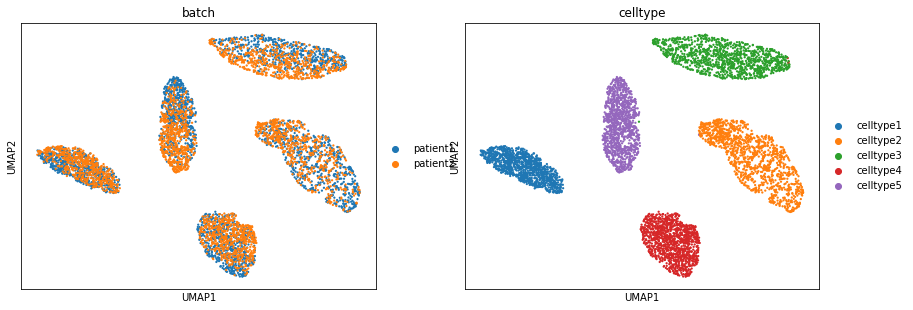

<Figure size 432x288 with 0 Axes>

In [5]:
sc.pp.neighbors(picasa_adata,use_rep='common')
sc.tl.umap(picasa_adata)
sc.pl.umap(picasa_adata,color=['batch','celltype'])
plt.tight_layout()

# Unique representation

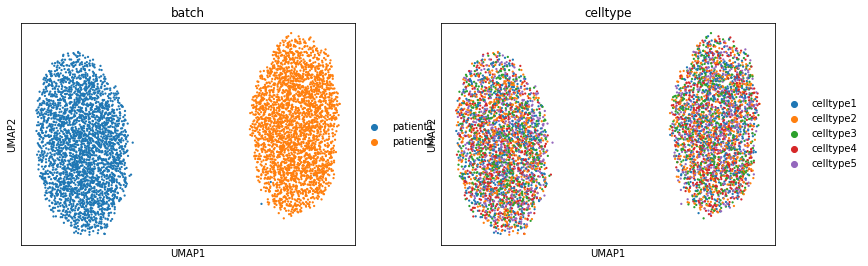

<Figure size 432x288 with 0 Axes>

In [6]:
sc.pp.neighbors(picasa_adata,use_rep='unique')
sc.tl.umap(picasa_adata)
sc.pl.umap(picasa_adata,color=['batch','celltype'])
plt.tight_layout()

# Base representation

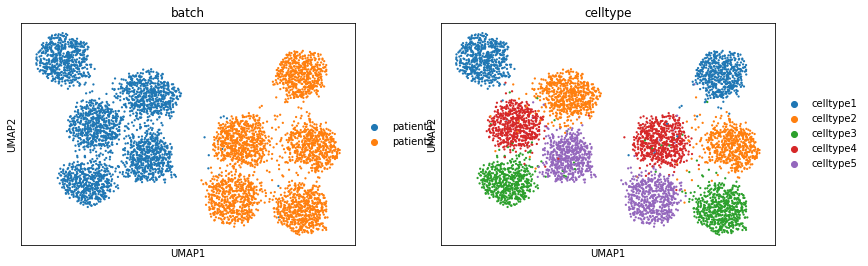

<Figure size 432x288 with 0 Axes>

In [7]:
sc.pp.neighbors(picasa_adata,use_rep='base')
sc.tl.umap(picasa_adata)
sc.pl.umap(picasa_adata,color=['batch','celltype'])
plt.tight_layout()